# Check Incoporation of `dt` into code repository

I've incorporated a `dt` timescale for discrete integration into `rnn.py`

The update looks something like this:

```
self.h = self.h + (-self.h + self.f(self.u) + self.xi)*self.dt/self.tau_rec
```

The term on the right was previously scaled by $1/\tau$, and is now scaled by $dt/\tau$. A value of `tau_rec=5` should now be changed to `0.5` if desired `dt=0.1`

Additionally, I've now scaled the noise in the recurrent units

```
xi/np.sqrt(self.dt)
```

For previous results using values of `sig_rec` such as `0.1`, new `sig_rec` values should be multiplied by $\sqrt{dt}$. For example, if `dt=0.1`, we want `0.1*0.31622 = 0.031622`. The total number of steps in the trial should be taken into account as well

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Training `w_rec` only using RFLO, with velocity transformation

Note that I also had to change the code in the following lines of the RFLO algorithm

```
if 'w_rec' in self.apply_to: 
    self.p = (1-rnn.dt/rnn.tau_rec)*self.p
    self.p += np.outer(rnn.df(rnn.u), rnn.h_prev)*rnn.dt/rnn.tau_rec
if 'w_in' in self.apply_to:
    self.q = (1-rnn.dt/rnn.tau_rec)*self.q
    self.q += np.outer(rnn.df(rnn.u), rnn.x_in_prev)*rnn.dt/rnn.tau_rec  
if 'w_fb' in self.apply_to:
    self.p_fb = (1-rnn.dt/rnn.tau_rec)*self.p_fb
    self.p_fb += np.outer(rnn.df(rnn.u), rnn.pos)*rnn.dt/rnn.tau_rec
```

6it [00:00, 54.71it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.0316227766016838
sig_out: 0.01
tau_rec: 0.5
dt: 0.1
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fe33e5c33f0>


500it [00:01, 278.57it/s]


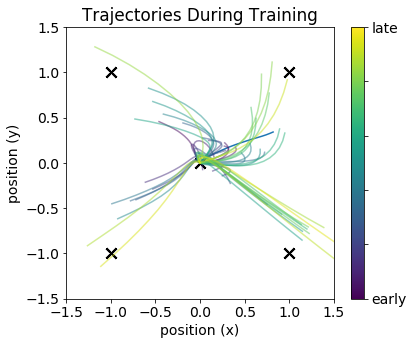

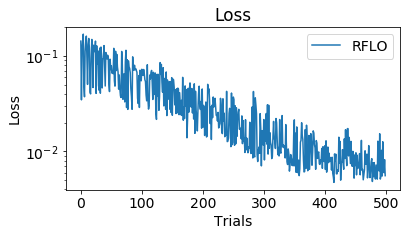

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=0.5,dt = 0.1, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1*np.sqrt(0.1),sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

params.print_params()

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=[], plot=True, plot_freq=10)


Note that we have not trained `w_out` at all, and are therefore forced to drive activity in a way that takes advantage of the readout matrix. We can also plot the trained trajectories

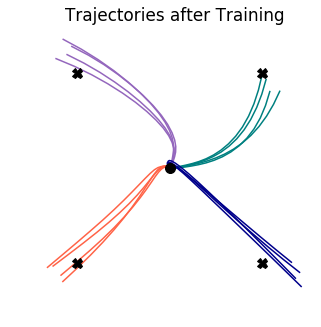

In [5]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


### 2. Training `w_rec` only, with BPTT

Note that I had to change BPTT in the following locations by including the factor rnn.dt

```
# Loop backwards through timesteps
for tt in range(t_max-1, 0, -1):
    z[tt-1] = z[tt]*(1 - rnn.dt/rnn.tau_rec)
    z[tt-1] += np.dot(rnn.w_m, self.err_history[tt]) # what are dimensions of rnn.err? It does not keep a history over timesteps!!
    z[tt-1] += np.dot(z[tt]*rnn.df(self.u_history[tt]), rnn.w_rec)*rnn.dt/rnn.tau_rec

    # Updates for the weights at each timestep backwards:
    if 'w_rec' in self.apply_to:
        self.dw_rec += rnn.eta_rec/(t_max*rnn.tau_rec/rnn.dt)*np.outer(z[tt]*rnn.df(self.u_history[tt]),
                                                self.h_history[tt-1])
    if 'w_in' in self.apply_to:
        self.dw_in += rnn.eta_in/(t_max*rnn.tau_rec/rnn.dt)*np.outer(z[tt]*rnn.df(self.u_history[tt]),
                                               self.x_in_history[tt])
```

8it [00:00, 79.03it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.0316227766016838
sig_out: 0.01
tau_rec: 0.5
dt: 0.1
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fabc3ec4f78>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


500it [00:01, 305.78it/s]


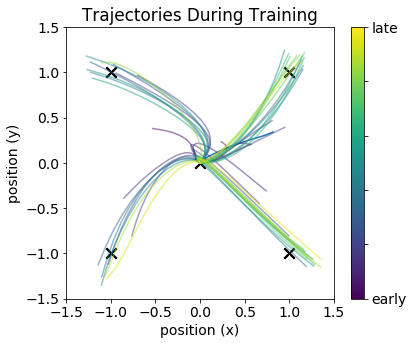

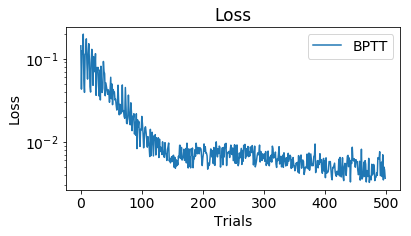

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=0.5,dt = 0.1, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1*np.sqrt(0.1),sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

params.print_params()

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_rec'],online=False) 

sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=[], plot=True, plot_freq=10)


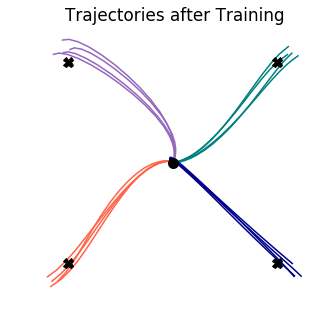

In [5]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


## Training W_rec with REINFORCE

Note that I had to change the following lines of code:

```
""" update must include noise rnn.xi inject to network recurrent layer """
if 'w_rec' in self.apply_to: 
    self.p = (1-rnn.dt/rnn.tau_rec)*self.p
    self.p += np.outer(rnn.xi*rnn.df(rnn.u), rnn.h_prev)*rnn.dt/rnn.tau_rec

if 'w_fb' in self.apply_to:
    self.p_fb = (1-rnn.dt/rnn.tau_rec)*self.p_fb
    self.p_fb += np.outer(rnn.xi*rnn.df(rnn.u), rnn.pos)*rnn.dt/rnn.tau_rec
            
```

as well as in the reward function:

```
 self.r_av_prev[task_idx] = self.r_av[task_idx]
            self.r_av[task_idx] = self.r_av_prev[task_idx] + (rnn.dt/self.tau_reward) * (rnn.r_current-self.r_av_prev[task_idx])
```

5000it [00:11, 440.69it/s]


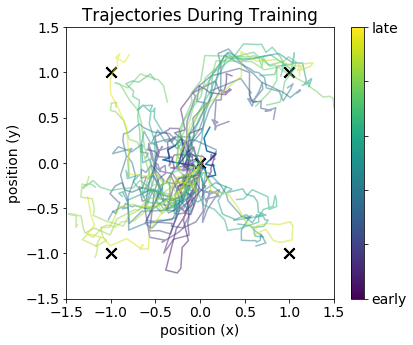

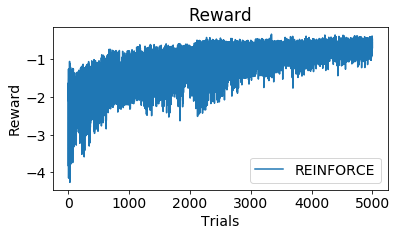

In [18]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5, dt = 1,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.01,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 2, dt_vel = 0.1,
               rng=np.random.RandomState(0))

# Initialize RNN
net = RNN(params)


# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5) 

sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['pos','reward'], plot=True, plot_freq=100)


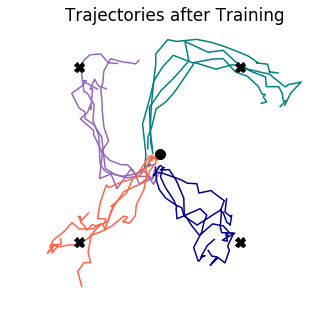

In [20]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


# Training for longer durations

What parameters should we keep in mind if we are simulating for `50` steps with a `dt=0.1`? Since the timescale of the simulation is 50, we need to `dt/tau_rec` to be on the order of $1/5$ to $1/10$ (i.e. a significant fraction of the full trial duration).

In [77]:
0.1/2 # equivalent to 1/20

0.05

In [59]:
trial_duration = 50
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### 1. Training `w_rec` only, with velocity transformation

7it [00:00, 68.52it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.0316227766016838
sig_out: 0.01
tau_rec: 1
dt: 0.1
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 5
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fddac45b438>


5000it [00:37, 82.66it/s]


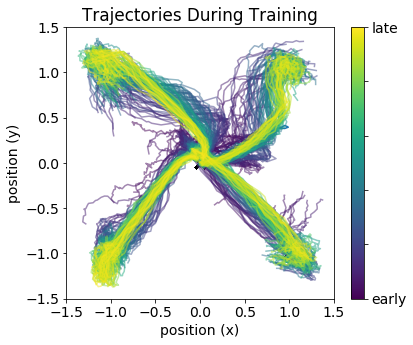

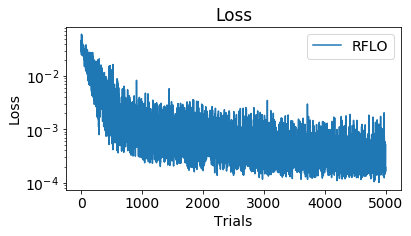

In [75]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=1,dt = 0.1, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1*np.sqrt(0.1),sig_out=0.01,
               velocity_transform=False, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

params.print_params()

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False) 
#bptt = BPTT(net,apply_to=['w_rec'],online=False) 

sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=[], plot=True, plot_freq=10)


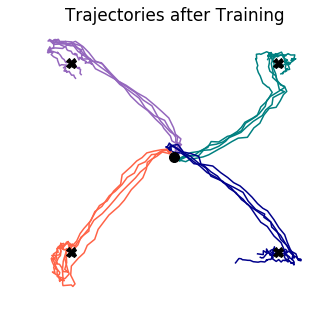

In [76]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])
